# L1 Regularization: Dataset 1

In [31]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy
import warnings

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

In [32]:
# Import user-defined modules
import sys
import imp
sys.path.append('/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockdown')
import tools_general as tg
import tools_pytorch as tp
import lockdown      as ld
imp.reload(tg)
imp.reload(tp)
imp.reload(ld)

<module 'lockdown' from '/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockdown/lockdown.py'>

## Read, clean, and save data

In [339]:
# Read X and y
X = pd.read_csv('/Users/arbelogonzalezw/Documents/ML_WORK/Project_Jerry_Lockdown/dataset_10LungCarcinoma/GDS3837_gene_profile.csv', index_col=0)
dfy = pd.read_csv('/Users/arbelogonzalezw/Documents/ML_WORK/Project_Jerry_Lockdown/dataset_10LungCarcinoma/GDS3837_output.csv', index_col=0)

In [340]:
# Change column names
cols = X.columns.tolist()
for i in range(len(cols)):
    cols[i] = cols[i].lower()
    cols[i] = cols[i].replace('-', '_')
    cols[i] = cols[i].replace('.', '_')
    cols[i] = cols[i].strip()
X.columns = cols

cols = dfy.columns.tolist()
for i in range(len(cols)):
    cols[i] = cols[i].lower()
    cols[i] = cols[i].replace('-', '_')
    cols[i] = cols[i].replace('.', '_')
    cols[i] = cols[i].strip()
dfy.columns = cols

# Set target
dfy['disease_state'] = dfy['disease_state'].str.replace(' ', '_')
dfy.replace({'disease_state': {"lung_cancer": 1, "control": 0}}, inplace=True)
Y = pd.DataFrame(dfy['disease_state'])

In [342]:
# Split and save data set
xtrain, xvalid, xtest, ytrain, yvalid, ytest = tg.split_data(X, Y)
tg.save_data(X, xtrain, xvalid, xtest, Y, ytrain, yvalid, ytest, 'dataset/')
tg.save_list(X.columns.to_list(), 'dataset/X.columns')
tg.save_list(Y.columns.to_list(), 'dataset/Y.columns')

# 
print("- X size: {}\n".format(X.shape))
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))

- X size: (120, 54675)

- xtrain size: (72, 54675)
- xvalid size: (24, 54675)
- xtest size: (24, 54675)


## Load Data

In [3]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


In [4]:
# Read data
X, x_train, x_valid, x_test, Y, ytrain, yvalid, ytest = tp.load_data_clf('dataset/')
cols_X = tg.read_list('dataset/X.columns')
cols_Y = tg.read_list('dataset/Y.columns')

In [5]:
# Normalize data
xtrain, xvalid, xtest = tp.normalize_x(x_train, x_valid, x_test)

In [6]:
# Create dataloaders
dl_train, dl_valid, dl_test = tp.make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                                  tp.dataset_tabular, batch_size=10000)

(train, valid, test) = (1, 1, 1)


In [7]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

* ## Lockout (L1)

In [33]:
# Initialize forward model
n_features = len(cols_X)
n_layers = [5, 2]
model = MyNet(n_features, n_layers)
model.eval()

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=54675, out_features=5, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=5, out_features=2, bias=True)
  )
)

In [13]:
# TRAIN WITH LOCKDOWN
model = MyNet(n_features, n_layers)
model.load_state_dict(torch.load('./model_forward_valid_min.pth'))
model.eval()

regul_type = [('classifier.0.weight', 1), ('classifier.2.weight', 1)]
regul_path = [('classifier.0.weight', True), ('classifier.2.weight', False)]

lockout = ld.lockdown(model, lr=1e-2, 
                      regul_type=regul_type, 
                      regul_path=regul_path, 
                      loss_type=2, tol_grads=1e-2)

In [14]:
lockout.train(dl_train, dl_valid, dl_test, epochs=5000, early_stop=15, tol_loss=5e-5, epochs2=100000,
              train_how="decrease_t0")

{'classifier.0.weight': tensor(597.2031), 'classifier.2.weight': tensor(2.2559)} {'classifier.0.weight': tensor(0.)}


Epochs1:   0%|          | 0/5000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 44


Epochs2:   0%|          | 0/100000 [00:00<?, ?it/s]

Best validation at iteration = 89955


In [35]:
# Save model, data
tp.save_model(lockout.model_best_valid, 'model_lockout_valid_min_l1.pth')
tp.save_model(lockout.model_last, 'model_lockout_last_l1.pth')
lockout.path_data.to_csv('data_lockout_l1.csv')

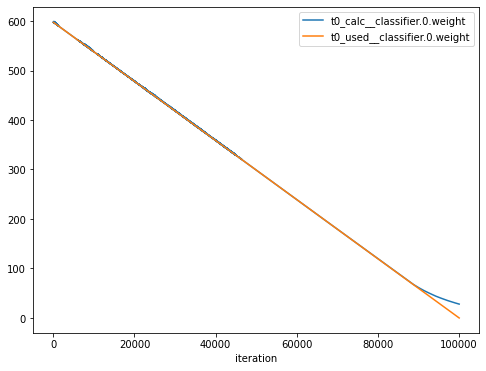

In [38]:
# Relevant plots
df = pd.read_csv('data_lockout_l1.csv')
df.plot('iteration', y=['t0_calc__classifier.0.weight', 't0_used__classifier.0.weight'], 
        figsize=(8,6))
plt.show()

In [47]:
# L1
nn = int(2e2)
data_tmp = pd.read_csv('data_lockout_l1.csv', index_col=0)
data_lockout_l1 = pd.DataFrame(columns=['sparcity', 'train_accu', 'valid_accu', 'test_accu', 't0_used'])
xgrid, step = np.linspace(0., 1., num=nn,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_tmp['sparcity__classifier.0.weight'] >= x) &    \
          (data_tmp['sparcity__classifier.0.weight'] < x+step)
    train_accu = data_tmp.loc[msk, 'train_accu'].mean()
    valid_accu = data_tmp.loc[msk, 'valid_accu'].mean()
    test_accu  = data_tmp.loc[msk, 'test_accu'].mean()
    t0_used = data_tmp.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_lockout_l1 = data_lockout_l1.append({'sparcity': x, 
                                             'train_accu': train_accu, 
                                             'valid_accu': valid_accu, 
                                             'test_accu': test_accu, 
                                             't0_used': t0_used}, ignore_index=True)
data_lockout_l1.dropna(axis='index', how='any', inplace=True)

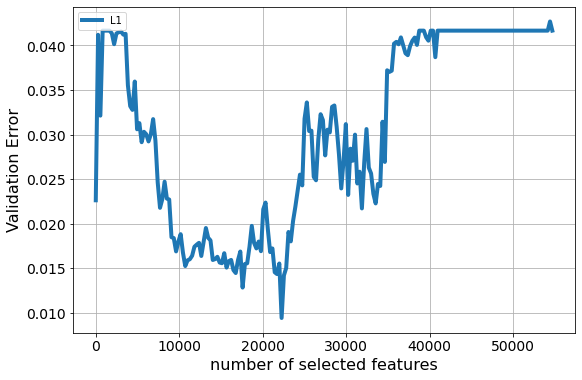

In [48]:
# L1
fig, axes = plt.subplots(figsize=(9,6))

axes.plot(n_features*data_lockout_l1['sparcity'], 
          1.0 - data_lockout_l1['valid_accu'], 
          "-", linewidth=4, markersize=10, label="L1")

axes.grid(True, zorder=2)
axes.set_xlabel("number of selected features", fontsize=16)
axes.set_ylabel("Validation Error", fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.legend()
# axes.set_xlim(1.0-1e-4,1.0)
plt.show()